<a href="https://colab.research.google.com/github/abdulwasaeee/Pytorch-Bootcamp/blob/main/pytorch-CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
import seaborn as sns


In [2]:
torch.__version__

'2.8.0+cu126'

In [3]:
torchvision.__version__

'0.23.0+cu126'

In [4]:
traindata=datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.55MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.41MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


In [5]:
test=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [6]:
len(traindata), len(test)

(60000, 10000)

In [7]:
classnames=traindata.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
classtoidx=traindata.class_to_idx
classtoidx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
image,label= traindata[0]
label

9

In [10]:
image.shape

torch.Size([1, 28, 28])

In [11]:
classnames[label]

'Ankle boot'

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

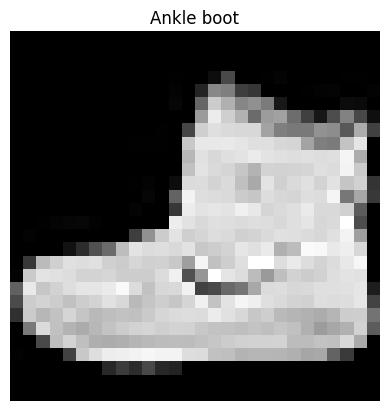

In [12]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(classnames[label])
plt.axis(False)

In [13]:
batchsize=32
dl=DataLoader(dataset=traindata, batch_size=batchsize, shuffle=False)
testdl=DataLoader(dataset=test, batch_size=batchsize, shuffle=False)

In [14]:
dl, testdl

(<torch.utils.data.dataloader.DataLoader at 0x7aa934924680>,
 <torch.utils.data.dataloader.DataLoader at 0x7aa9349241a0>)

In [15]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnlayers=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(kernel_size=2,stride=2),
    )
    self.linearlayers=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*7*7,out_features=128),
        nn.ReLU(),
        nn.Linear(128,10)
    )

  def forward(self,x):
    x=self.cnlayers(x)
    x=self.linearlayers(x)
    return x


In [16]:
model=CNN()

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CNN(
  (cnlayers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [18]:
opt= torch.optim.Adam(params=model.parameters(),lr=0.01)
lossfn=nn.CrossEntropyLoss()

In [19]:
dl.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [20]:
len(dl), len(dl.dataset)

(1875, 60000)

In [21]:
def training(model, dataloader, lossfn, optimizer, device="cpu"):
  model.train()
  totalloss=0
  for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        ypred = model(x)
        loss = lossfn(ypred, y)
        loss.backward()
        optimizer.step()
        totalloss += loss.item()
  return totalloss / len(dataloader)

In [22]:
def testing(model, dataloader, lossfn, device="cpu"):
  model.eval()
  totalloss=0
  correct=0

  with torch.inference_mode():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss = lossfn(ypred, y)
            totalloss += loss.item()
            preds = ypred.argmax(dim=1)
            correct += (preds == y).sum().item()
  return totalloss / len(dataloader), correct / len(testdl.dataset)

In [23]:
torch.manual_seed(42)
start = timer()

epochs = 5

for i in tqdm(range(epochs)):
    trainloss= training(model, dl, lossfn, opt, device=device)
    testloss, testacc= testing(model, testdl, lossfn, device=device)
end = timer()
totaltime = end - start
print(f"Total training time: {totaltime:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Total training time: 63.710 seconds


In [24]:
print(trainloss,testloss,testacc)

0.33409571856061615 0.43618182480906525 0.8602


In [25]:
pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.1 MB/s eta 0:00:00


In [27]:
from torchmetrics.classification import ConfusionMatrix

In [29]:
pl=[]
ll=[]

In [31]:
model.eval()
with torch.inference_mode():
        for x, y in testdl:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            preds = ypred.argmax(dim=1)
            pl.append(preds)
            ll.append(y)
pl=torch.cat(pl)
ll=torch.cat(ll)


In [33]:
cm=ConfusionMatrix(task='multiclass', num_classes=10).to(device)

In [46]:
cm=cm.to(device)

In [47]:
cm(pl.to(device), ll.to(device))

tensor([[856,   0,  69,  20,   4,   0,  48,   0,   3,   0],
        [  2, 952,   6,  32,   5,   0,   2,   0,   1,   0],
        [  5,   1, 864,  12,  71,   0,  47,   0,   0,   0],
        [ 31,   1,  34, 901,  17,   0,  15,   0,   1,   0],
        [  1,   0, 141,  46, 760,   0,  52,   0,   0,   0],
        [  1,   0,   0,   0,   0, 978,   1,  17,   1,   2],
        [205,   0, 133,  29,  73,   0, 557,   0,   3,   0],
        [  0,   0,   2,   0,   0,  10,   0, 981,   1,   6],
        [  0,   0,  31,   3,   2,   4,  16,   1, 943,   0],
        [  1,   0,   7,   0,   0,  96,   0,  86,   0, 810]], device='cuda:0')

<Axes: >

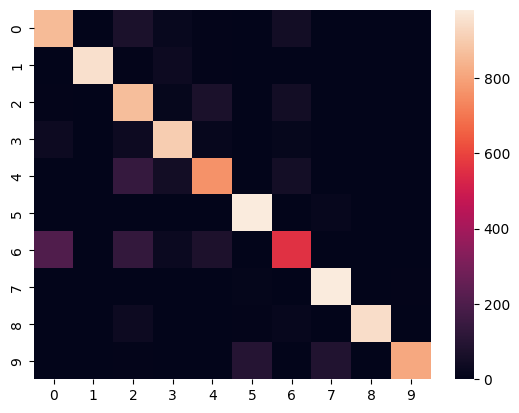

In [48]:
sns.heatmap(cm(pl.to(device), ll.to(device)).cpu().numpy())

In [50]:
model.state_dict()

OrderedDict([('cnlayers.0.weight',
              tensor([[[[-0.4776, -0.8282,  0.0320],
                        [-0.3624, -1.0922, -0.4756],
                        [-0.2704,  0.0851,  0.1339]]],
              
              
                      [[[-0.1603, -0.1190, -0.1150],
                        [-0.1051, -0.1748, -0.0756],
                        [-0.1961, -0.1804, -0.0580]]],
              
              
                      [[[-0.4499, -1.7785, -0.0314],
                        [-0.3961, -3.9545, -2.1948],
                        [ 0.5377, -0.3277, -0.2135]]],
              
              
                      [[[ 0.0311, -0.0185,  0.0280],
                        [-0.2494, -0.2880,  0.0621],
                        [-0.0095, -0.0147,  0.1393]]],
              
              
                      [[[-0.7062, -0.3969, -0.4382],
                        [ 0.1525, -0.5616, -0.0705],
                        [ 0.0312, -0.6592, -0.5116]]],
              
              
          

In [51]:
torch.save(model,'model.pt')